Output()

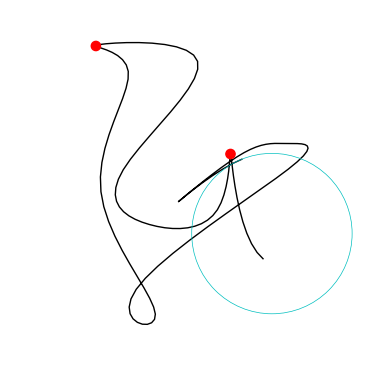

In [88]:
# Load the required libraries.
import ipywidgets as widgets
import math
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import threading
import time
from IPython.display import clear_output
from IPython.display import display
from matplotlib.path import Path

import splinekit as sk # This library

# Setup
support = 15 # Length of the displayed splines
oversampling = 10 # Samples per unit length
hertz = 12 # Refresh rate
kink_radius = 1 / 50 # Minimal radius below which the curve is said to have a kink

# Inter-thread communication
thread = threading.local()
thread.out = widgets.Output() # Display
thread.oc = True # Show the osculating circle
thread.kink = True # Show the kinks
thread.resume_event = threading.Event() # Handshake
thread.forever = True # Handshake

# Initialize the plot and loop over updates
def start_animation(thread):
    t = 0 # Initial time
    # Initial continuously defined horizontal spline coordinates
    s1 = sk.PeriodicSpline1D.from_spline_coeff(np.random.standard_normal(support + 2), degree = 3)
    # Initial continuously defined vertical spline coordinates
    s2 = sk.PeriodicSpline1D.from_spline_coeff(np.random.standard_normal(support + 2), degree = 3)
    # Initial coordinate samples
    x1 = s1.get_samples(0, support_length = support, oversampling = oversampling)
    x2 = s2.get_samples(0, support_length = support, oversampling = oversampling)
    # Initial coordinate gradients
    dx1 = s1.gradient().get_samples(0, support_length = support, oversampling = oversampling)
    dx2 = s2.gradient().get_samples(0, support_length = support, oversampling = oversampling)
    # Initial coordinate second-order derivatives
    ddx1 = s1.differentiated(2).get_samples(0, support_length = support, oversampling = oversampling)
    ddx2 = s2.differentiated(2).get_samples(0, support_length = support, oversampling = oversampling)
    def osculating_signed_radius(k):
        return (math.sqrt(dx1[k] ** 2 + dx2[k] ** 2) ** 3) / (dx1[k] * ddx2[k] - ddx1[k] * dx2[k])
    # Initial radiuses of the osculating circles
    r = np.array([osculating_signed_radius(k) for k in range(x1.size)], dtype = float)
    # Initial trailing spline coefficients
    c1 = np.array(s1.spline_coeff[support - 3 : support + 1], dtype = float)
    c2 = np.array(s2.spline_coeff[support - 3 : support + 1], dtype = float)
    # Precomputed B-spline weights
    w = np.array(
        [
            [
                sk.b_spline(k - 1 - t / oversampling, 3)
                for k in range(4)
            ]
            for t in range(oversampling)
        ],
        dtype = float
    )
    # Precomputed B-spline gradient weights
    dw = np.array(
        [
            [
                sk.grad_b_spline(k - 1 - t / oversampling, 3)
                for k in range(4)
            ]
            for t in range(oversampling)
        ],
        dtype = float
    )
    # Precomputed B-spline second-derivative weights
    ddw = np.array(
        [
            [
                sk.diff_b_spline(
                    k - 1 - t / oversampling,
                    degree = 3,
                    differentiation_order = 2
                )
                for k in range(4)
            ]
            for t in range(oversampling)
        ],
        dtype = float
    )

    # Clean slate
    clear_output(wait = False)
    thread["out"].clear_output(wait = False)

    # Allow for pause, resume, and stop Buttons
    toggle_buttons = widgets.ToggleButtons(
        options = ["Pause", "Resume", "Stop"],
        index = 1
    )
    def on_toggle_changed(value):
        if "Pause" == toggle_buttons.value:
            thread["resume_event"].clear()
        elif "Resume" == toggle_buttons.value:
            thread["resume_event"].set()
        elif "Stop" == toggle_buttons.value:
            thread["resume_event"].set()
            thread["forever"] = False
            box.layout.display = "none"
    toggle_buttons.observe(on_toggle_changed, names = "value")
    # Display of the oscillating circle
    oc_checkbox = widgets.Checkbox(value = thread["oc"], description = "Show Osculating Circle")
    def on_oc_checkbox_changed(value):
        thread["oc"] = oc_checkbox.value
    oc_checkbox.observe(on_oc_checkbox_changed, names = "value")
    # Display of the kinks
    kink_checkbox = widgets.Checkbox(value = thread["kink"], description = "Show Kinks")
    def on_kink_checkbox_changed(value):
        thread["kink"] = kink_checkbox.value
    kink_checkbox.observe(on_kink_checkbox_changed, names = "value")

    # Layout of the interactive panel
    box = widgets.VBox([widgets.HBox([toggle_buttons]), oc_checkbox, kink_checkbox])
    display(box, thread["out"])

    # Layout of the plot
    (fig, ax) = plt.subplots()
    ax.set_aspect(1)
    ax.spines.top.set_visible(False)
    ax.spines.left.set_visible(False)
    ax.spines.bottom.set_visible(False)
    ax.spines.right.set_visible(False)
    plt.tick_params(bottom = False, labelbottom = False, left = False, labelleft = False)
    hdisplay = display("", display_id = True)

    # Update of the plot
    def update_plot(ax, *, hdisplay):
        nonlocal t, x1, x2, dx1, dx2, ddx1, ddx2, r, c1, c2
        if 0 == t % oversampling:
            t = 0
            # Innovation, create new trailing coefficients
            c1[0] = np.random.standard_normal()
            c1 = np.roll(c1, -1)
            c2[0] = np.random.standard_normal()
            c2 = np.roll(c2, -1)
        x1[0] = w[t] @ c1 # New horizontal coordinate trailing sample
        dx1[0] = dw[t] @ c1 # Horizontal gradient
        ddx1[0] = ddw[t] @ c1 # Horizontal second-order derivative
        x2[0] = w[t] @ c2 # New vertical coordinate trailing sample
        dx2[0] = dw[t] @ c2 # Vertical gradient
        ddx2[0] = ddw[t] @ c2 # Vertical second-order derivative
        r[0] = osculating_signed_radius(0) # Radius of the osculating circle
        # Center of the osculating circle
        o1 = x1[0] - r[0] * dx2[0] / math.sqrt(dx1[0] ** 2 + dx2[0] ** 2)
        o2 = x2[0] + r[0] * dx1[0] / math.sqrt(dx1[0] ** 2 + dx2[0] ** 2)
        # Running window
        x1 = np.roll(x1, -1)
        x2 = np.roll(x2, -1)
        dx1 = np.roll(dx1, -1)
        dx2 = np.roll(dx2, -1)
        ddx1 = np.roll(ddx1, -1)
        ddx2 = np.roll(ddx2, -1)
        r = np.roll(r, -1)
        # New graph
        ax.clear()
        verts = np.transpose([x1, x2])
        codes = [Path.MOVETO] + [Path.LINETO for _ in range(1, x1.size)] 
        path = Path(verts, codes)
        patch = patches.PathPatch(path, fill = False)
        ax.add_patch(patch) # Spline curve
        if thread["oc"]: # Osculating circle
            patch = patches.Circle((o1, o2), r[-1], fill = False, color = "c", linewidth = 0.5)
            ax.add_patch(patch)
        if thread["kink"]: # Kinks
            for k in range(r.size):
                if abs(r[k]) < kink_radius:
                    ax.add_patch(patches.Circle((x1[k], x2[k]), 0.05, color = "r"))
        # Do plot the graph update
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        plt.close(fig)
        hdisplay.update(fig)
        t += 1

    # Never stop
    while thread["forever"]:
        thread["resume_event"].wait()
        update_plot(ax, hdisplay = hdisplay)
        time.sleep(1.0 / hertz)

# Start the animation and leave
t = threading.Thread(target = start_animation, args = [thread.__dict__])
t.start()
thread.resume_event.set()
